<a href="https://colab.research.google.com/github/rajeevfromkrec/pytorch/blob/master/Cifar10%20%20Image%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import tarfile
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

In [4]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

In [5]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [6]:
!ls

cifar10.tgz  data  sample_data


In [7]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test', 'labels.txt']
['ship', 'cat', 'truck', 'airplane', 'deer', 'frog', 'horse', 'automobile', 'bird', 'dog']


In [8]:
airplanes_files= os.listdir(data_dir+'/train/airplane')
print(len(airplanes_files))
airplanes_files[:6]

5000


['1607_airplane.png',
 '45716_airplane.png',
 '12029_airplane.png',
 '29348_airplane.png',
 '48136_airplane.png',
 '22084_airplane.png']

In [9]:
from torchvision.datasets import ImageFolder

In [10]:
dataset=ImageFolder(data_dir+'/train',transform=ToTensor())

In [11]:
image,label=dataset[0]

In [12]:
def display_image(datasets):
  image,label= datasets
  print(dataset.classes[label])
  plt.imshow(image.permute(1,2,0))


In [13]:
type(label)

int

In [14]:
dataset.classes[0]

'airplane'

airplane


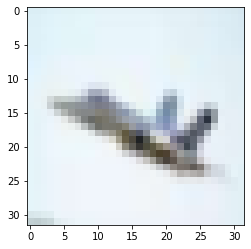

In [15]:
display_image(dataset[0])

automobile


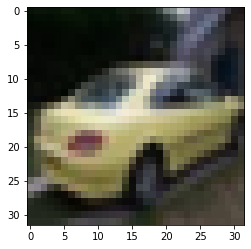

In [16]:
display_image(dataset[6000])

In [17]:
random_seed=41
torch.manual_seed(random_seed)

In [18]:
val_size=5000
train_size=len(dataset)-val_size

train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(45000, 5000)

In [19]:
batch_size=128

train_loader= DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader= DataLoader(val_ds,batch_size,num_workers=4,pin_memory=True)

In [20]:
from torchvision.utils import make_grid

In [21]:
def show_batch(dl):
  for image,label in dl:
    fig,ax=plt.subplots(figsize=(16,6))
    print(label)
    plt.imshow(make_grid(image ,nrow=16).permute(1,2,0))
    break

tensor([2, 6, 1, 7, 6, 7, 9, 8, 8, 1, 5, 9, 3, 2, 8, 3, 5, 7, 8, 3, 9, 2, 0, 4,
        7, 5, 1, 1, 3, 7, 2, 5, 9, 5, 2, 7, 5, 1, 7, 7, 0, 0, 9, 8, 4, 9, 6, 0,
        1, 2, 4, 0, 1, 1, 8, 1, 7, 9, 5, 7, 4, 2, 0, 0, 5, 3, 4, 0, 2, 4, 2, 1,
        3, 6, 5, 8, 6, 3, 9, 7, 0, 7, 1, 0, 9, 6, 2, 5, 5, 5, 1, 7, 9, 1, 7, 7,
        1, 3, 0, 6, 9, 1, 6, 0, 0, 2, 3, 1, 1, 5, 4, 9, 2, 5, 1, 3, 4, 1, 0, 6,
        9, 8, 5, 8, 0, 5, 9, 1])


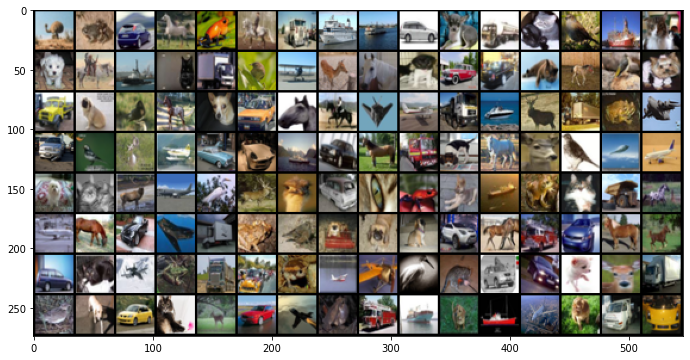

In [22]:
show_batch(train_loader)

In [23]:
simple_model= nn.Sequential(
              nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),
              nn.MaxPool2d(2,2)

)

In [24]:
for images,labels in train_loader:
  print(images.shape)
  out=simple_model(images)
  print(out.shape)
  #print(out)
  break

torch.Size([128, 3, 32, 32])
torch.Size([128, 8, 16, 16])


In [25]:
def accuracy(outputs, labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
class ImageClassificaionBase(nn.Module):

  def training_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    acc=accuracy(out,labels)
    return { 'val_loss':loss.detach(),'val_acc':acc } 

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
    epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [27]:
class cifar10ImageClassifiction(ImageClassificaionBase):
  def __init__(self):
    super().__init__()

    self.network=nn.Sequential(
        
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        

        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(1024*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,10 ))
  def forward(self,xb):
    return self.network(xb)




In [28]:
model=cifar10ImageClassifiction()

In [29]:
model

cifar10ImageClassifiction(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=16384, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, 

In [30]:
for images,labels in train_loader:
  out=model(images)
  print(out[0])
  break

tensor([-0.0393,  0.0093,  0.0316, -0.0001,  0.0210, -0.0447, -0.0267,  0.0343,
        -0.0404, -0.0190], grad_fn=<SelectBackward>)


In [31]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
device = get_default_device()
device

device(type='cuda')

In [33]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:
model = to_device(cifar10ImageClassifiction(), device)

In [36]:
evaluate(model, val_dl)

{'val_acc': 0.09746094048023224, 'val_loss': 2.303572416305542}

In [37]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8563, val_loss: 1.5211, val_acc: 0.4314
Epoch [1], train_loss: 1.3299, val_loss: 1.1602, val_acc: 0.5756
Epoch [2], train_loss: 1.0497, val_loss: 0.9711, val_acc: 0.6549
Epoch [3], train_loss: 0.8397, val_loss: 0.8174, val_acc: 0.7078
Epoch [4], train_loss: 0.6940, val_loss: 0.7679, val_acc: 0.7301
Epoch [5], train_loss: 0.5711, val_loss: 0.7718, val_acc: 0.7354
Epoch [6], train_loss: 0.4656, val_loss: 0.7025, val_acc: 0.7699
Epoch [7], train_loss: 0.3726, val_loss: 0.7215, val_acc: 0.7697
Epoch [8], train_loss: 0.2872, val_loss: 0.8709, val_acc: 0.7455
Epoch [9], train_loss: 0.2225, val_loss: 0.9576, val_acc: 0.7494


In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

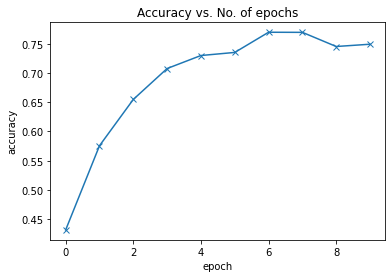

In [39]:
plot_accuracies(history)

In [40]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

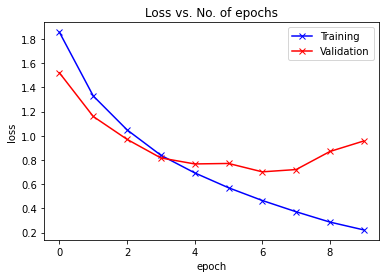

In [41]:
plot_losses(history)

In [42]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [44]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
img, label = test_dataset[144]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))